# Simple Semantic Search

In [13]:
from sentence_transformers import SentenceTransformer, util
import pandas as pd
import torch
import pickle 
import os

In [14]:
# === 1. Load model IndoSBERT dari Denaya ===
model = SentenceTransformer("denaya/indoSBERT-large")

In [15]:
# === 2. Load dataset ===
df = pd.read_csv("../quran_id_full.csv")
texts = df['indoText'].tolist()

In [7]:
# === 3. Cek apakah embedding sudah disimpan ===
embedding_file = "quran_id_full_embedding_indosbert.pkl"
if os.path.exists(embedding_file):
    with open(embedding_file, "rb") as f:
        embeddings = pickle.load(f)
    print("✅ Embedding berhasil dimuat dari file.")
else:
    embeddings = model.encode(texts, convert_to_tensor=True, show_progress_bar=True)
    with open(embedding_file, "wb") as f:
        pickle.dump(embeddings, f)
    print("✅ Embedding berhasil dihitung dan disimpan.")

Batches:   0%|          | 0/195 [00:00<?, ?it/s]

✅ Embedding berhasil dihitung dan disimpan.


In [13]:
# === 4. Proses IR / Semantic Search ===
def search(query, top_k=5):
    query_embedding = model.encode(query, convert_to_tensor=True)
    hits = util.semantic_search(query_embedding, embeddings, top_k=top_k)[0]
    results = []
    for hit in hits:
        idx = hit['corpus_id']
        score = hit['score']
        results.append((df.iloc[idx]['suraId'], df.iloc[idx]['verseID'], df.iloc[idx]['indoText'], score))
    return results

In [16]:
# === 5. Contoh Query ===
query = "kasih sayang Tuhan"
hasil = search(query, 20)

In [17]:
# === 6. Cetak hasil pencarian ===
for surah, ayat, text, score in hasil:
    print(f"[{surah}:{ayat}] (score: {score:.4f})\n{text}\n")

[26:217] (score: 0.7148)
Dan bertawakallah kepada (Allah) Yang Mahaperkasa, Maha Penyayang.

[55:1] (score: 0.7148)
(Allah) Yang Maha Pengasih,

[1:3] (score: 0.7097)
Yang Maha Pengasih, Maha Penyayang,

[1:1] (score: 0.7073)
Dengan nama Allah Yang Maha Pengasih, Maha Penyayang.

[26:9] (score: 0.7032)
Dan sungguh, Tuhanmu Dialah Yang Mahaperkasa, Maha Penyayang.

[74:3] (score: 0.6962)
dan agungkanlah Tuhanmu,

[26:68] (score: 0.6944)
Dan sesungguhnya Tuhanmu Dialah Yang Mahaperkasa, Maha Penyayang.

[26:159] (score: 0.6940)
Dan sungguh, Tuhanmu, Dialah Yang Mahaperkasa, Maha Penyayang.

[26:122] (score: 0.6940)
Dan sungguh, Tuhanmu, Dialah Yang Mahaperkasa, Maha Penyayang.

[26:191] (score: 0.6940)
Dan sungguh, Tuhanmu, Dialah yang Mahaperkasa, Maha Penyayang.

[26:140] (score: 0.6940)
Dan sungguh, Tuhanmu, Dialah Yang Mahaperkasa, Maha Penyayang.

[26:175] (score: 0.6940)
Dan sungguh, Tuhanmu, Dialah Yang Mahaperkasa, Maha Penyayang.

[26:104] (score: 0.6940)
Dan sungguh, Tuhanmu be

# Cek Max Seq Len

In [ ]:
tokenizer = model.tokenizer 
max_len = model.max_seq_length 

In [17]:
def count_tokens(text):
    return len(tokenizer.tokenize(text))

In [20]:
jumlah_token_ayats = [count_tokens(text) for text in texts]

Token indices sequence length is longer than the specified maximum sequence length for this model (317 > 256). Running this sequence through the model will result in indexing errors


In [25]:
import numpy as np

token_array = np.array(jumlah_token_ayats)
print("Min   :", np.min(token_array))
print("Max   :", np.max(token_array))
print("Mean  :", np.mean(token_array))
print("Median:", np.median(token_array))
print("Std   :", np.std(token_array))

Min   : 2
Max   : 317
Mean  : 34.24326491340603
Median: 28.0
Std   : 24.38255472348762


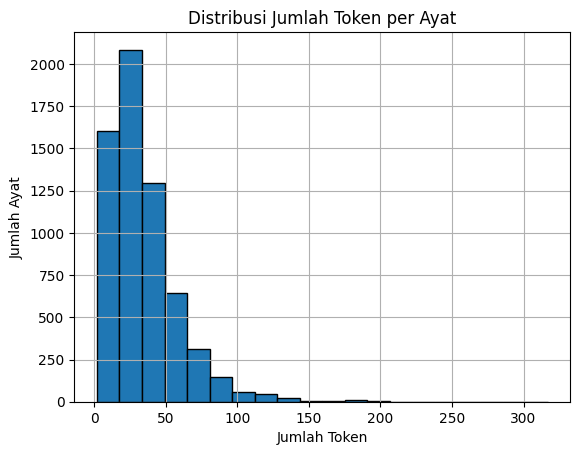

In [21]:
import matplotlib.pyplot as plt

plt.hist(jumlah_token_ayats, bins=20, edgecolor='black')
plt.title("Distribusi Jumlah Token per Ayat")
plt.xlabel("Jumlah Token")
plt.ylabel("Jumlah Ayat")
plt.grid(True)
plt.show()

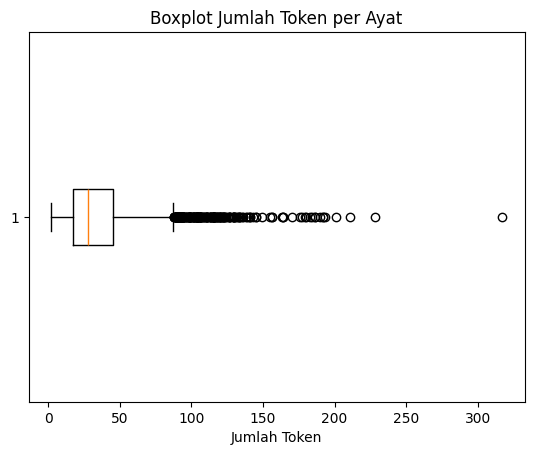

In [22]:
plt.boxplot(jumlah_token_ayats, vert=False)
plt.title("Boxplot Jumlah Token per Ayat")
plt.xlabel("Jumlah Token")
plt.show()

# Manualisasi

In [1]:
import pandas as pd
import torch
from sentence_transformers import SentenceTransformer, util
from transformers import AutoTokenizer, AutoModel
from torch.nn.functional import cosine_similarity
import torch.nn.functional as F


In [2]:
# Load dataset
df = pd.read_csv("alfatihah.csv")

# Ambil teks ayat saja
texts = df['indoText'].tolist()
texts

['Dengan nama Allah Yang Maha Pengasih, Maha Penyayang.',
 'Segala puji bagi Allah, Tuhan seluruh alam,',
 'Yang Maha Pengasih, Maha Penyayang,',
 'Pemilik hari pembalasan.',
 'Hanya kepada Engkaulah kami menyembah dan hanya kepada Engkaulah kami mohon pertolongan.',
 'Tunjukilah kami jalan yang lurus,',
 '(yaitu) jalan orang-orang yang telah Engkau beri nikmat kepadanya; bukan (jalan) mereka yang dimurkai, dan bukan (pula jalan) mereka yang sesat.']

In [3]:
query = "apa itu jalan yang lurus"

In [4]:
MODEL_NAME = "denaya/indoSBERT-large"

## encode()

In [60]:
model = SentenceTransformer(MODEL_NAME)
model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 1024, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Dense({'in_features': 1024, 'out_features': 256, 'bias': True, 'activation_function': 'torch.nn.modules.activation.Tanh'})
)

In [61]:
embeddings = model.encode(texts, convert_to_tensor=True, show_progress_bar=True)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

In [62]:
def search(query, top_k=5):
    query_embedding = model.encode(query, convert_to_tensor=True)
    hits = util.semantic_search(query_embedding, embeddings, top_k=top_k)[0]
    results = []
    for hit in hits:
        idx = hit['corpus_id']
        score = hit['score']
        results.append((df.iloc[idx]['suraId'], df.iloc[idx]['verseID'], df.iloc[idx]['indoText'], score))
    return results

In [63]:
hasil = search(query)

In [64]:
for surah, ayat, text, score in hasil:
    print(f"[{surah}:{ayat}] (score: {score:.4f})\n{text}\n")

[1:6] (score: 0.7579)
Tunjukilah kami jalan yang lurus,

[1:7] (score: 0.5341)
(yaitu) jalan orang-orang yang telah Engkau beri nikmat kepadanya; bukan (jalan) mereka yang dimurkai, dan bukan (pula jalan) mereka yang sesat.

[1:4] (score: 0.2791)
Pemilik hari pembalasan.

[1:3] (score: 0.2710)
Yang Maha Pengasih, Maha Penyayang,

[1:5] (score: 0.2643)
Hanya kepada Engkaulah kami menyembah dan hanya kepada Engkaulah kami mohon pertolongan.



## Replikasi sbert encode()

In [5]:
from sentence_transformers import SentenceTransformer
import torch
import torch.nn.functional as F

# Load full SentenceTransformer model
sbert_model = SentenceTransformer(MODEL_NAME)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Ambil komponen: tokenizer, transformer, pooling, dense
tokenizer = sbert_model.tokenizer
transformer = sbert_model[0].auto_model.to(device)       
pooling_config = sbert_model[1]              
dense_layer = sbert_model[2].to(device)           


In [10]:
sbert_model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 256, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 1024, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Dense({'in_features': 1024, 'out_features': 256, 'bias': True, 'activation_function': 'torch.nn.modules.activation.Tanh'})
)

In [8]:
W = dense_layer.linear.weight.detach().cpu().numpy() 
b = dense_layer.linear.bias.detach().cpu().numpy() 

print(W.shape)
print(b.shape)

(256, 1024)
(256,)


In [9]:
pd.DataFrame(W).to_csv("dense_weights.csv", index=False, header=False, float_format="%.10f")
pd.DataFrame(b.reshape(1, -1)).to_csv("dense_bias.csv", index=False, header=False, float_format="%.10f")

In [11]:
def sbert_manual_encode(sentences):
    # Tokenisasi
    encoded = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt').to(device)

    # Decode token ID ke bentuk token string (subword)
    input_ids = encoded['input_ids'][0]
    tokens = tokenizer.convert_ids_to_tokens(input_ids)

    # Forward BERT
    with torch.no_grad():
        model_output = transformer(**encoded)

    # Mean pooling
    attention_mask = encoded['attention_mask']
    token_embeddings = model_output.last_hidden_state
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size())
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    pooled_embeddings = sum_embeddings / sum_mask

    # Dense + tanh
    features = {"sentence_embedding": pooled_embeddings}
    projected = dense_layer(features)["sentence_embedding"]

    print("=== Tokenisasi ===")
    print(f"Teks input      : {sentences[0]}")
    print(f"Token/subword   : {tokens}")
    print(f"Token IDs       : {input_ids.tolist()}")
    print()

    print("=== Representasi ===")
    print(f"Attention Mask      : {attention_mask.shape} → {attention_mask[0].tolist()}")
    print(f"Token Embeddings    : {token_embeddings.shape} → {token_embeddings}")
    print(f"Pooled Embedding    : {pooled_embeddings.shape} → {pooled_embeddings}")
    print(f"Features            : {features}")
    print(f"Projected Embedding : {projected.shape}")
    print(f"Encoded             : {projected}")
    print()

    return projected


In [12]:
# Encode seluruh ayat
corpus_embeddings = [sbert_manual_encode([text])[0].to(device) for text in texts]

=== Tokenisasi ===
Teks input      : Dengan nama Allah Yang Maha Pengasih, Maha Penyayang.
Token/subword   : ['[CLS]', 'dengan', 'nama', 'allah', 'yang', 'maha', 'pengasih', ',', 'maha', 'penyayang', '.', '[SEP]']
Token IDs       : [2, 79, 712, 763, 34, 4262, 24896, 30468, 4262, 20900, 30470, 3]

=== Representasi ===
Attention Mask      : torch.Size([1, 12]) → [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Token Embeddings    : torch.Size([1, 12, 1024]) → tensor([[[-1.9847, -1.4915,  0.7932,  ..., -1.3205,  0.6599,  1.0398],
         [-0.6687, -2.1191,  0.2913,  ..., -0.5696, -0.6184,  0.0598],
         [-0.4466, -1.6551,  0.2009,  ..., -0.0600, -0.1337,  0.8507],
         ...,
         [-0.1964, -0.4056, -0.5559,  ..., -0.7900, -0.0893,  0.7731],
         [-0.4073, -1.0020, -0.1562,  ..., -1.5810, -1.2614,  0.4719],
         [-1.9847, -1.4915,  0.7932,  ..., -1.3205,  0.6599,  1.0398]]],
       device='cuda:0')
Pooled Embedding    : torch.Size([1, 1024]) → tensor([[-0.4900, -0.9775,  0.0884,  .

In [14]:
corpus_embeddings

[tensor([-0.3103,  0.0476, -0.2136,  0.5747, -0.5802,  0.3460, -0.4193,  0.1167,
          0.2573, -0.4526,  0.1514, -0.0981, -0.3991, -0.4193, -0.2804, -0.7975,
          0.6950,  0.4902, -0.4850,  0.4661,  0.1072,  0.3930,  0.3746,  0.4349,
          0.2037, -0.2722, -0.2832,  0.3372,  0.6899, -0.0186, -0.5194, -0.1102,
         -0.1236, -0.3300, -0.2468, -0.5211,  0.1951, -0.1522, -0.3664, -0.2216,
          0.1474,  0.7370, -0.2054,  0.1046, -0.5949, -0.1824, -0.3134, -0.4164,
          0.3121, -0.4304,  0.1923,  0.1614, -0.0977, -0.1498,  0.4054,  0.3014,
         -0.1037,  0.5202, -0.3706, -0.3481, -0.3562, -0.4616, -0.2310, -0.6271,
         -0.0459, -0.8212, -0.6108,  0.1246, -0.7267, -0.1515,  0.6396,  0.4990,
          0.0490,  0.6834, -0.2039, -0.4276,  0.2823, -0.4554, -0.0534, -0.4972,
         -0.8492, -0.1401, -0.3377,  0.1592, -0.2054,  0.0566, -0.8531, -0.3593,
          0.5321,  0.6889,  0.3784,  0.3347,  0.2432, -0.0972,  0.3854, -0.3708,
          0.2495, -0.3846,  

In [18]:
import numpy as np
array_corpus_embeddings = np.stack([t.detach().cpu().numpy() for t in corpus_embeddings]) 

In [19]:
df_corpus_embeddings = pd.DataFrame(array_corpus_embeddings)
df_corpus_embeddings.to_csv("corpus_embeddings.csv", index=False)
df_corpus_embeddings

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
0,-0.310290,0.047604,-0.213563,0.574729,-0.580175,0.345966,-0.419347,0.116702,0.257346,-0.452631,...,0.546591,-0.113299,-0.274497,0.100855,-0.399132,-0.085710,0.339930,0.448266,-0.553782,0.215556
1,-0.111778,0.219245,-0.296038,0.478775,-0.762114,0.166548,-0.210124,0.046831,-0.057612,0.314603,...,0.439193,0.639585,-0.559022,0.523507,-0.488721,-0.673003,0.018004,-0.195581,-0.577659,-0.212472
2,-0.567327,-0.120209,-0.112982,0.576418,-0.615292,0.317989,-0.309543,0.013519,0.030270,-0.468995,...,0.392361,0.115505,-0.268147,0.063557,-0.351850,-0.356569,0.267553,0.386437,-0.363346,0.310667
3,-0.233072,0.266337,-0.207151,-0.647345,-0.410976,0.268319,-0.413726,-0.007439,0.474925,0.172163,...,0.531387,-0.599912,0.610343,-0.486428,-0.183692,0.178677,0.280552,0.260683,-0.226640,0.179522
4,0.406519,0.106281,0.161641,0.229408,-0.437315,-0.282212,-0.153943,0.368268,-0.270375,-0.122104,...,0.620451,0.307719,-0.537755,0.319022,-0.477281,-0.144636,0.161547,0.602512,-0.236525,0.367259
5,0.526509,-0.060712,0.059696,0.452729,-0.454680,0.156511,-0.391873,0.518938,0.232897,-0.594114,...,-0.234770,0.135533,-0.128335,0.871197,-0.173221,-0.173126,0.020026,0.493722,0.129979,0.626449
6,-0.050671,-0.075922,-0.117811,-0.101637,-0.113417,-0.170070,-0.087608,-0.098443,0.065899,-0.436860,...,-0.390231,0.357770,0.099087,0.370807,-0.435797,-0.167272,0.227661,0.006540,0.012666,0.226702


### Query Embedding Detail

In [23]:
torch.set_printoptions(threshold=torch.inf, precision=6, sci_mode=False)

In [20]:
# Tokenisasi
sentences = query
encoded = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt').to(device)

# Decode token ID ke bentuk token string (subword)
input_ids = encoded['input_ids'][0]
tokens = tokenizer.convert_ids_to_tokens(input_ids)

# Forward BERT
with torch.no_grad():
    model_output = transformer(**encoded)

# Mean pooling
attention_mask = encoded['attention_mask']
token_embeddings = model_output.last_hidden_state
input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size())
sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
pooled_embeddings = sum_embeddings / sum_mask

# Dense + tanh
features = {"sentence_embedding": pooled_embeddings}
projected = dense_layer(features)["sentence_embedding"]

In [21]:
print("=== Tokenisasi ===")
print(f"Teks input      : {sentences[0]}")
print(f"Token/subword   : {tokens}")
print(f"Token IDs       : {input_ids.tolist()}")
print()

=== Tokenisasi ===
Teks input      : a
Token/subword   : ['[CLS]', 'apa', 'itu', 'jalan', 'yang', 'lurus', '[SEP]']
Token IDs       : [2, 387, 137, 795, 34, 5971, 3]



In [22]:
print("=== Representasi ===")
print(f"Attention Mask      : {attention_mask.shape} → {attention_mask[0].tolist()}")
print(f"Token Embeddings    : {token_embeddings.shape} → {token_embeddings}")
print(f"Pooled Embedding    : {pooled_embeddings.shape} → {pooled_embeddings}")
print(f"Features            : {features}")
print(f"Projected Embedding : {projected.shape}")
print(f"Encoded             : {projected}")
print()

=== Representasi ===
Attention Mask      : torch.Size([1, 7]) → [1, 1, 1, 1, 1, 1, 1]
Token Embeddings    : torch.Size([1, 7, 1024]) → tensor([[[-1.2988, -0.5830,  0.7943,  ..., -1.6688,  1.5489,  0.0948],
         [ 0.3435,  0.7282, -0.0464,  ..., -0.4292, -0.4913,  0.4488],
         [ 0.1737,  0.4020, -0.2984,  ..., -0.1378, -0.0046, -0.0439],
         ...,
         [-0.4131,  0.3648, -0.7312,  ..., -0.2980,  0.1134,  0.5581],
         [-0.4215,  0.5851, -0.6554,  ...,  0.8085,  0.6076,  0.3909],
         [-1.2988, -0.5830,  0.7943,  ..., -1.6688,  1.5489,  0.0948]]],
       device='cuda:0')
Pooled Embedding    : torch.Size([1, 1024]) → tensor([[-0.4721,  0.0307, -0.0524,  ..., -0.4312,  0.4985,  0.3221]],
       device='cuda:0')
Features            : {'sentence_embedding': tensor([[ 0.4061,  0.0227,  0.0597,  0.5108, -0.3708, -0.0151, -0.4917,  0.7308,
         -0.1104,  0.1829, -0.0098, -0.2261, -0.0127, -0.3909,  0.2944, -0.4739,
          0.5531, -0.2437, -0.3850,  0.0153,  0.668

In [24]:
print(token_embeddings.shape)
print(token_embeddings)


torch.Size([1, 7, 1024])
tensor([[[    -1.298754,     -0.582990,      0.794331,     -0.004025,
               0.990074,      0.546900,     -0.450689,     -1.029518,
               0.531548,      0.761083,     -0.407662,     -0.349334,
              -0.732595,      0.010659,     -0.355734,     -0.006442,
              -0.403463,     -1.217209,     -1.583502,     -0.808772,
               1.081350,      1.265898,      1.409867,      1.263075,
              -0.528850,      0.098940,      0.116762,     -0.145394,
               0.450833,      1.277076,     -0.191765,      0.300285,
              -0.145141,     -0.720589,      0.124533,     -2.785822,
               1.849713,     -1.086618,     -1.436712,      0.432097,
              -1.362271,      0.302680,     -0.242974,     -0.337537,
              -0.452045,      0.820300,      0.735463,      0.786994,
               0.185144,      1.240778,     -0.104568,     -2.342621,
               0.505126,     -0.592238,     -1.031955,      1.798

In [25]:
array_token_embeddings = []

# Loop per token (dimensi ke-1)
for token_vec in token_embeddings[0]:  # shape [7, 1024]
    array_token_embeddings.append(token_vec.cpu().numpy()) 

df_token_embeddings = pd.DataFrame(array_token_embeddings)  # shape [7, 1024]
df_token_embeddings.to_csv("token_embeddings.csv", sep=';', index=False)
df_token_embeddings

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,-1.298754,-0.582990,0.794331,-0.004025,0.990074,0.546900,-0.450689,-1.029518,0.531548,0.761083,...,-0.004202,0.597128,-0.877189,-0.106537,0.784689,-1.885138,0.748926,-1.668780,1.548934,0.094784
1,0.343501,0.728174,-0.046408,-0.613719,1.036273,0.445212,-0.076236,-0.262040,0.825977,0.213676,...,1.401505,0.820308,-0.264954,-0.833534,0.294099,-0.324129,0.177720,-0.429246,-0.491296,0.448836
2,0.173654,0.401990,-0.298407,-0.374125,0.714150,-0.167384,0.542257,-0.487342,0.393198,0.349810,...,1.229867,-0.169769,-1.055203,-0.635334,0.444059,-0.590902,0.596889,-0.137800,-0.004598,-0.043894
3,-0.390004,-0.699273,-0.224275,-0.378033,1.128926,0.404276,0.874239,-0.091399,0.170339,0.615618,...,0.192268,0.782529,-0.204544,-0.456791,-0.043472,0.168795,0.433719,0.375915,0.166530,0.710975
4,-0.413092,0.364848,-0.731192,0.112858,0.695809,-0.136299,0.986048,0.169094,0.558994,0.551740,...,1.128487,0.545514,-0.334758,-1.143098,0.240800,-0.730736,-0.263043,-0.297975,0.113351,0.558115
5,-0.421497,0.585077,-0.655386,0.036711,0.799556,0.046479,0.437706,0.439146,0.515526,0.752662,...,0.682149,0.737787,0.074293,-0.942296,0.409242,0.311774,0.152507,0.808502,0.607610,0.390916
6,-1.298754,-0.582991,0.794331,-0.004025,0.990073,0.546900,-0.450689,-1.029518,0.531548,0.761083,...,-0.004202,0.597128,-0.877189,-0.106537,0.784689,-1.885138,0.748926,-1.668780,1.548934,0.094784


In [26]:
print(pooled_embeddings.shape)
pd.DataFrame(pooled_embeddings.cpu().numpy())

torch.Size([1, 1024])


,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,-0.472135,0.030691,-0.052429,-0.174909,0.907837,0.240869,0.266091,-0.327368,0.503876,0.572239,...,0.660839,0.558661,-0.505649,-0.603447,0.416301,-0.705068,0.370806,-0.431166,0.498495,0.322074


In [28]:
with torch.no_grad():
    x = pooled_embeddings  # shape: [1, 1024]
    W = dense_layer.linear.weight         # shape: [256, 1024]
    b = dense_layer.linear.bias         # shape: [256]

    x_w = torch.matmul(x, W.T) 
    xw_b = x_w + b        # shape: [1, 256]
    output = torch.tanh(xw_b)               # apply activation

    print(f"X * W      : {x_w.shape} → \n{x_w}")
    print(f"X * W + b  : {xw_b.shape} → \n{xw_b}")
    print(f"Activation : {output.shape} → \n{output}")


X * W      : torch.Size([1, 256]) → 
tensor([[     0.414162,     -0.005759,      0.067837,      0.542718,
             -0.370976,     -0.044820,     -0.549938,      0.943161,
             -0.112686,      0.213540,      0.016051,     -0.201064,
              0.013323,     -0.410432,      0.285151,     -0.502381,
              0.611431,     -0.237633,     -0.388030,      0.007553,
              0.818859,      0.219998,     -0.730265,     -0.059362,
              0.199538,     -0.056365,     -0.530595,     -0.376830,
             -0.214739,      0.297778,      0.058146,     -0.131366,
              0.222730,     -0.000735,      0.147284,     -0.829754,
              0.782814,     -0.440286,     -0.778342,     -0.322482,
              0.879049,      0.710361,     -0.208099,      0.431455,
             -0.681202,     -0.059352,     -0.194754,      0.212934,
              0.215643,     -0.387013,     -0.203710,     -0.206736,
             -0.356707,      0.176467,      0.241614,     -0.14441

In [29]:
projected

tensor([[ 0.406118,  0.022681,  0.059671,  0.510845, -0.370818, -0.015097,
         -0.491670,  0.730797, -0.110421,  0.182884, -0.009774, -0.226140,
         -0.012711, -0.390923,  0.294396, -0.473890,  0.553112, -0.243746,
         -0.385048,  0.015334,  0.668642,  0.233305, -0.623853, -0.050463,
          0.202298, -0.053578, -0.475085, -0.381569, -0.208881,  0.282576,
          0.044119, -0.110947,  0.216867,  0.005567,  0.167837, -0.692515,
          0.663916, -0.429073, -0.641279, -0.330058,  0.695894,  0.612786,
         -0.233447,  0.417916, -0.594026, -0.076097, -0.188451,  0.211219,
          0.228321, -0.352560, -0.204799, -0.230067, -0.359061,  0.186821,
          0.237940, -0.112622, -0.706524, -0.286438, -0.472114,  0.124737,
          0.656705,  0.608456, -0.593156, -0.621706,  0.348513, -0.516675,
         -0.189247, -0.465928, -0.166676,  0.504503,  0.296663, -0.244693,
          0.814215,  0.673731,  0.141448,  0.278726,  0.365443, -0.387069,
         -0.400397, -0.57

In [30]:
query_embedding = sbert_manual_encode([query])[0].to(device)

=== Tokenisasi ===
Teks input      : apa itu jalan yang lurus
Token/subword   : ['[CLS]', 'apa', 'itu', 'jalan', 'yang', 'lurus', '[SEP]']
Token IDs       : [2, 387, 137, 795, 34, 5971, 3]

=== Representasi ===
Attention Mask      : torch.Size([1, 7]) → [1, 1, 1, 1, 1, 1, 1]
Token Embeddings    : torch.Size([1, 7, 1024]) → tensor([[[    -1.298754,     -0.582990,      0.794331,     -0.004025,
               0.990074,      0.546900,     -0.450689,     -1.029518,
               0.531548,      0.761083,     -0.407662,     -0.349334,
              -0.732595,      0.010659,     -0.355734,     -0.006442,
              -0.403463,     -1.217209,     -1.583502,     -0.808772,
               1.081350,      1.265898,      1.409867,      1.263075,
              -0.528850,      0.098940,      0.116762,     -0.145394,
               0.450833,      1.277076,     -0.191765,      0.300285,
              -0.145141,     -0.720589,      0.124533,     -2.785822,
               1.849713,     -1.086618,     -

In [32]:
query_embedding = query_embedding.unsqueeze(0)  # shape: [1, 256]
query_embedding.shape

torch.Size([1, 256])

In [33]:
from torch.nn.functional import cosine_similarity

similarities = cosine_similarity(query_embedding, corpus_embeddings) 

TypeError: cosine_similarity(): argument 'x2' (position 2) must be Tensor, not list

In [80]:
top_k = torch.topk(similarities, k=5)
indices = top_k.indices
scores = top_k.values

In [81]:
for idx, score in zip(indices, scores):
    ayat = df.iloc[idx.item()]
    print(f"[{ayat['suraId']}:{ayat['verseID']}] (score: {score:.4f})\n{ayat['indoText']}\n")

[1:6] (score: 0.7579)
Tunjukilah kami jalan yang lurus,

[1:7] (score: 0.5341)
(yaitu) jalan orang-orang yang telah Engkau beri nikmat kepadanya; bukan (jalan) mereka yang dimurkai, dan bukan (pula jalan) mereka yang sesat.

[1:4] (score: 0.2791)
Pemilik hari pembalasan.

[1:3] (score: 0.2710)
Yang Maha Pengasih, Maha Penyayang,

[1:5] (score: 0.2643)
Hanya kepada Engkaulah kami menyembah dan hanya kepada Engkaulah kami mohon pertolongan.

